<a href="https://colab.research.google.com/github/ymerta/sms-spam-classification-NLP/blob/main/spamClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yakupmertakan","key":"8f927b208e0ae8851389420a9fbf5aed"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 671MB/s]


In [4]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import pandas as pd

# Read the dataset (adjust encoding if necessary)
df = pd.read_csv("spam.csv", encoding='latin-1')

# Keep only relevant columns: 'v1' as label, 'v2' as message text
df = df[['v1', 'v2']]
df.columns = ['label', 'text']  # Rename columns for clarity

# Drop rows with missing values (if any)
df.dropna(inplace=True)

# Reset index after cleanup
df.reset_index(drop=True, inplace=True)

# Display the first 5 rows
print(df.head())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


# Tokenization

In [7]:
from nltk.tokenize import RegexpTokenizer

# Create a tokenizer that extracts only alphabetic words (ignores numbers and punctuation)
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

# Convert text to lowercase and apply the tokenizer to each message
df["tokens"] = df["text"].astype(str).str.lower().apply(lambda x: tokenizer.tokenize(x))

# Display the first 5 tokenized messages
print("Tokenized text:", *df["tokens"][:5], sep="\n")

Tokenized text:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


# Stopwords ve Most Frequent Words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-8-88dd3216344a>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


Cleaned tokens (stopwords + noise removed):
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


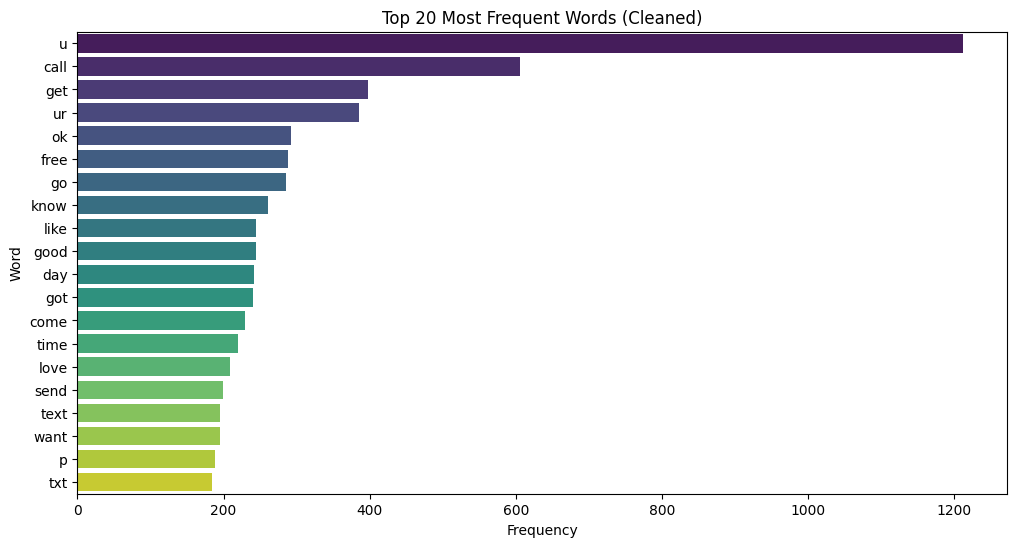

In [8]:
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download the list of English stopwords (only needed once)
nltk.download('stopwords')

# Define stopwords and additional domain-specific noise words
stop_words = set(stopwords.words('english'))
noise_words = ['lt', 'gt', 'rcv', 'msg', 'reply', 'decimal']

# Remove stopwords, noise words, and non-alphabetic tokens
df['clean_tokens'] = df['tokens'].apply(
    lambda tokens: [word for word in tokens if word.isalpha()
                    and word not in stop_words and word not in noise_words]
)

# Display a few cleaned token lists for inspection
print("Cleaned tokens (stopwords + noise removed):", *df['clean_tokens'][:5], sep="\n")

# Flatten all cleaned tokens into a single list
all_words = [word for tokens in df['clean_tokens'] for word in tokens]

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the top 20 most frequent words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

# Plot the top 20 most frequent words
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Most Frequent Words (Cleaned)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

In [9]:
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary lexical resources for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to each word in the 'clean_tokens' list
df['lemmatized_tokens'] = df['clean_tokens'].apply(
    lambda tokens: [lemmatizer.lemmatize(w) for w in tokens]
)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [11]:
# Collect all unique 1- and 2-letter words from the lemmatized tokens
short_words = sorted(set(
    word for tokens in df['lemmatized_tokens'] for word in tokens if len(word) <= 2
))

# Print the list of short words
print("1- or 2-letter words:")
for word in short_words:
    print(word)

1- or 2-letter words:
aa
ab
ac
ad
ae
ag
ah
aj
ak
al
am
an
aq
ar
as
av
ax
ay
b
ba
bb
bc
bf
bk
bp
bt
bw
bx
c
cc
cd
ch
cl
cm
cn
co
cr
ct
cw
da
db
dd
de
di
dl
dp
dr
dt
dx
e
ea
ec
ed
ee
eg
eh
el
em
en
er
ew
ex
ey
ez
f
fa
fb
ff
fl
fm
fo
fr
ft
g
ga
gb
gd
ge
gf
gm
gn
go
gr
gv
h
ha
hb
he
hf
hg
hi
hl
hm
ho
hp
hr
hu
hv
hw
ia
ic
id
ie
ig
il
im
ip
iq
iz
j
ja
jb
jd
je
ji
jo
jp
jx
jy
k
kb
ke
kg
ki
kl
ko
kr
kz
l
la
lb
ld
le
lf
li
lk
lo
lp
lv
m
ma
mb
mc
mf
mg
mi
mj
mk
ml
mm
mn
mo
mp
mr
mt
mu
mw
n
na
nb
nd
ne
nh
ni
no
nr
nt
nu
nw
ny
nz
o
oh
oi
ok
or
ou
ow
oz
p
pa
pc
pe
pg
ph
pl
pm
po
pp
pt
pw
px
q
qf
qi
qp
qu
r
rd
rg
ro
rp
rr
rt
ru
rv
rw
s
sc
sd
se
sf
sg
sh
si
sk
sm
sn
so
sp
sq
sr
st
sw
t
ta
tb
tc
te
tf
tg
th
ti
tm
tp
tr
tt
tv
u
ud
uh
uk
um
un
ur
us
uv
uz
v
va
vl
vu
w
wa
wb
wc
wi
wk
wn
wo
wp
wq
wr
wt
wu
wv
wx
x
xe
xh
xn
xt
xx
xy
ya
yf
yi
ym
yo
yr
yt
z
zf


In [12]:
# Define a list of short and likely meaningless words to remove (1–2 letter words and uncommon 3-letter codes)
remove_words = [
    'aa', 'ab', 'ac', 'ad', 'ae', 'ag', 'ah', 'aj', 'ak', 'al', 'am', 'an', 'aq', 'ar', 'as', 'av', 'ax', 'ay',
    'b', 'ba', 'bb', 'bc', 'bf', 'bk', 'bp', 'bt', 'bw', 'bx',
    'c', 'cc', 'cd', 'ch', 'cl', 'cm', 'cn', 'co', 'cr', 'ct', 'cw',
    'da', 'db', 'dd', 'de', 'di', 'dl', 'dp', 'dr', 'dt', 'dx',
    'e', 'ea', 'ec', 'ed', 'ee', 'eg', 'eh', 'el', 'em', 'en', 'er', 'ew', 'ex', 'ey', 'ez',
    'f', 'fa', 'fb', 'ff', 'fl', 'fm', 'fo', 'fr', 'ft',
    'g', 'ga', 'gb', 'gd', 'ge', 'gf', 'gm', 'gn', 'go', 'gr', 'gv',
    'h', 'ha', 'hb', 'he', 'hf', 'hg', 'hi', 'hl', 'hm', 'ho', 'hp', 'hr', 'hu', 'hv', 'hw',
    'ia', 'ic', 'id', 'ie', 'ig', 'il', 'im', 'ip', 'iq', 'iz',
    'j', 'ja', 'jb', 'jd', 'je', 'ji', 'jo', 'jp', 'jx', 'jy',
    'k', 'kb', 'ke', 'kg', 'ki', 'kl', 'ko', 'kr', 'kz',
    'l', 'la', 'lb', 'ld', 'le', 'lf', 'li', 'lk', 'lo', 'lp', 'lv',
    'm', 'ma', 'mb', 'mc', 'mf', 'mg', 'mi', 'mj', 'mk', 'ml', 'mm', 'mn', 'mo', 'mp', 'mr', 'mt', 'mu', 'mw',
    'n', 'na', 'nb', 'nd', 'ne', 'nh', 'ni', 'no', 'nr', 'nt', 'nu', 'nw', 'ny', 'nz',
    'o', 'oh', 'oi', 'ok', 'or', 'ou', 'ow', 'oz',
    'p', 'pa', 'pc', 'pe', 'pg', 'ph', 'pl', 'pm', 'po', 'pp', 'pt', 'pw', 'px',
    'q', 'qf', 'qi', 'qp', 'qu',
    'r', 'rd', 'rg', 'ro', 'rp', 'rr', 'rt', 'ru', 'rv', 'rw',
    's', 'sc', 'sd', 'se', 'sf', 'sg', 'sh', 'si', 'sk', 'sm', 'sn', 'so', 'sp', 'sq', 'sr', 'st', 'sw',
    't', 'ta', 'tb', 'tc', 'te', 'tf', 'tg', 'th', 'ti', 'tm', 'tp', 'tr', 'tt', 'tv',
    'u', 'ud', 'uh', 'uk', 'um', 'un', 'ur', 'us', 'uv', 'uz',
    'v', 'va', 'vl', 'vu',
    'w', 'wa', 'wb', 'wc', 'wi', 'wk', 'wn', 'wo', 'wp', 'wq', 'wr', 'wt', 'wu', 'wv', 'wx',
    'x', 'xe', 'xh', 'xn', 'xt', 'xx', 'xy',
    'ya', 'yf', 'yi', 'ym', 'yo', 'yr', 'yt',
    'z', 'zf'
]

# Remove all tokens in the 'remove_words' list from the lemmatized tokens
df['lemmatized_tokens'] = df['lemmatized_tokens'].apply(
    lambda tokens: [word for word in tokens if word not in remove_words]
)

In [13]:
from collections import Counter

# Collect all 3-letter words from the lemmatized token lists
three_letter_words = [
    word for tokens in df['lemmatized_tokens'] for word in tokens if len(word) == 3
]

# Get a sorted list of unique 3-letter words
unique_3_letters = sorted(set(three_letter_words))

# Print the unique 3-letter words
print("3-letter words:")
for word in unique_3_letters:
    print(word)

3-letter words:
aah
abi
abj
abt
acc
acl
aco
act
add
adi
adp
aft
age
ago
aha
aid
aig
air
aka
ali
ami
amk
amp
amt
amy
ana
aom
ape
apo
app
apr
apt
ard
arm
arr
art
asa
ash
ask
asp
ate
atm
ava
ave
avo
aww
ayn
ayo
bac
bad
bag
bak
bam
ban
bao
bar
bat
bay
bbc
bbd
bbq
bck
bcm
bcz
bec
bed
beg
ben
bet
bid
big
bin
bit
biz
blu
bmw
bob
boo
bos
bot
box
boy
bpo
bra
brb
bro
bsn
btw
bud
bun
bus
buy
bye
cab
cal
cam
cap
car
cat
cbe
cer
cha
chg
chk
cld
cme
cnl
cnn
com
con
cop
coz
cps
cro
cry
csc
csh
cst
cud
cum
cup
cut
cuz
cya
dad
dai
dan
dao
dat
day
dec
def
del
dem
den
der
dey
dha
die
din
dip
dis
dlf
dnt
dob
doc
dog
dom
dot
dry
dsn
dub
due
dun
duo
dvd
dvg
dwn
ear
eat
edu
eek
egg
ego
ela
emc
enc
end
eng
epi
ere
erm
err
ese
eta
etc
eva
eve
evn
evo
evr
exe
exp
ext
eye
fab
fal
fan
far
fat
fav
feb
fed
fee
fil
fit
fix
fly
fml
fne
fox
fps
fri
frm
fro
ful
fun
fwd
fyi
gal
gam
gap
gas
gay
gbp
gee
gei
gek
gep
ger
get
gin
giv
glo
gmw
god
gon
got
gpu
gre
grl
grr
gua
gud
gut
guy
gym
haf
hai
ham
hat
hav
hcl
hdd
hee
hen


In [14]:
# Count the frequency of each 3-letter word and get the top 50 most common ones
three_letter_freq = Counter(three_letter_words).most_common(50)

# Print the top 50 most frequent 3-letter words along with their counts
print("Most frequent 3-letter words:")
for word, freq in three_letter_freq:
    print(f"{word}: {freq}")

Most frequent 3-letter words:
get: 408
day: 291
got: 240
txt: 184
one: 184
lor: 162
see: 158
new: 136
pls: 134
min: 129
say: 119
hey: 112
wat: 107
yes: 103
way: 103
www: 100
let: 97
ask: 89
win: 88
amp: 86
com: 76
lol: 74
buy: 67
box: 62
guy: 62
per: 59
wan: 57
dun: 55
lot: 55
gud: 55
end: 54
may: 50
yet: 50
thk: 50
use: 49
try: 49
ppm: 49
god: 48
car: 46
man: 46
job: 45
bit: 44
yup: 43
ill: 42
dat: 42
sir: 39
lar: 38
eat: 38
boy: 38
pic: 38


In [15]:
keep_3 = {
    'get', 'day', 'one', 'see', 'new', 'min', 'say', 'hey', 'yes', 'way',
    'let', 'ask', 'win', 'com', 'buy', 'box', 'per', 'lot', 'end', 'may',
    'yet', 'use', 'try', 'god', 'car', 'man', 'job', 'bit', 'eat', 'boy'
}

In [16]:
# Keep only the 3-letter words listed in keep_3 and remove the rest
df['lemmatized_tokens'] = df['lemmatized_tokens'].apply(
    lambda tokens: [word for word in tokens if not (len(word) == 3 and word not in keep_3)]
)

In [17]:
# Print the first few rows of the cleaned lemmatized tokens
print("Cleaned example:")
print(df['lemmatized_tokens'].head())

Cleaned example:
0    [jurong, point, crazy, available, bugis, great...
1                                             [joking]
2    [free, entry, wkly, comp, win, final, tkts, ma...
3                           [say, early, already, say]
4                        [think, life, around, though]
Name: lemmatized_tokens, dtype: object


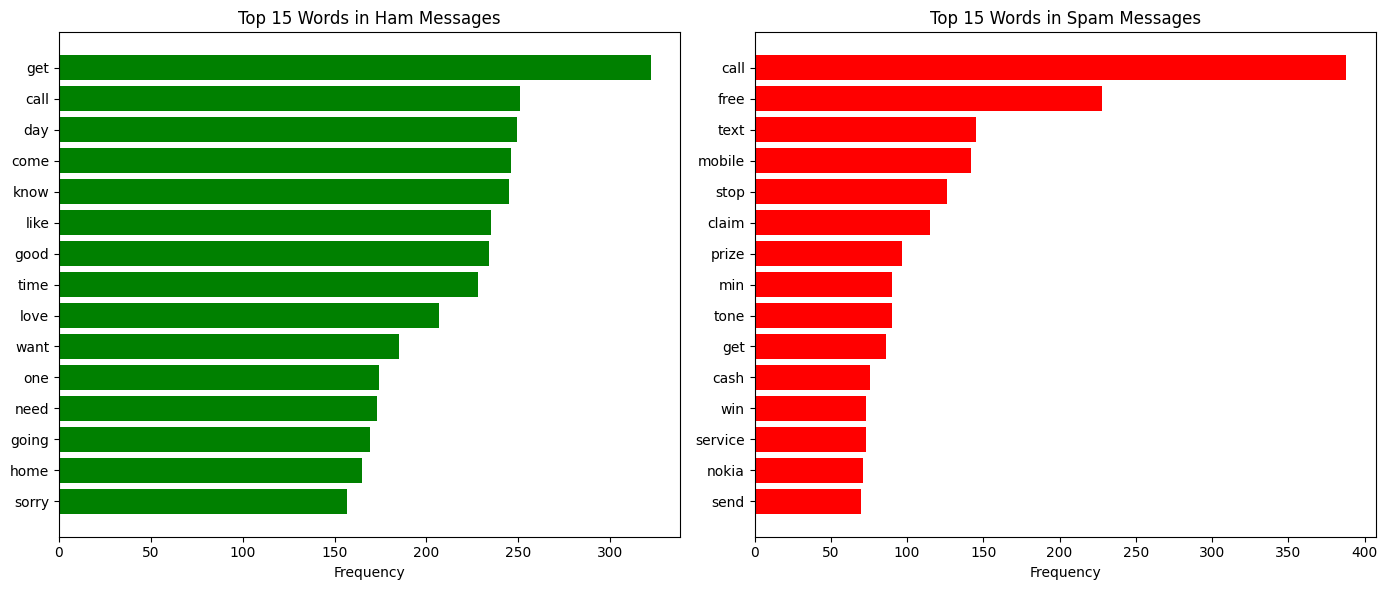

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten and collect all lemmatized words from ham and spam messages separately
ham_words = [word for tokens in df[df['label'] == 'ham']['lemmatized_tokens'] for word in tokens]
spam_words = [word for tokens in df[df['label'] == 'spam']['lemmatized_tokens'] for word in tokens]

# Count word frequencies in ham and spam messages
ham_freq = Counter(ham_words).most_common(15)
spam_freq = Counter(spam_words).most_common(15)

# Create a side-by-side bar plot for the top 15 words
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot ham word frequencies
axes[0].barh(*zip(*reversed(ham_freq)), color='green')
axes[0].set_title("Top 15 Words in Ham Messages")
axes[0].set_xlabel("Frequency")

# Plot spam word frequencies
axes[1].barh(*zip(*reversed(spam_freq)), color='red')
axes[1].set_title("Top 15 Words in Spam Messages")
axes[1].set_xlabel("Frequency")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# Bigram Trigram Analysis

<ipython-input-19-1549c8bf8276>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=vocab, palette='mako')


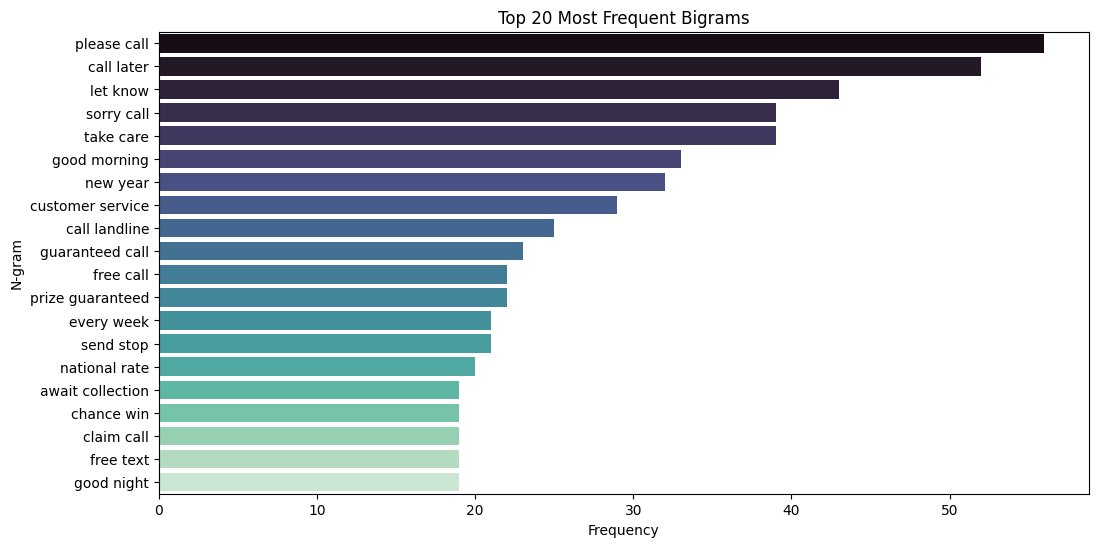

<ipython-input-19-1549c8bf8276>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=vocab, palette='mako')


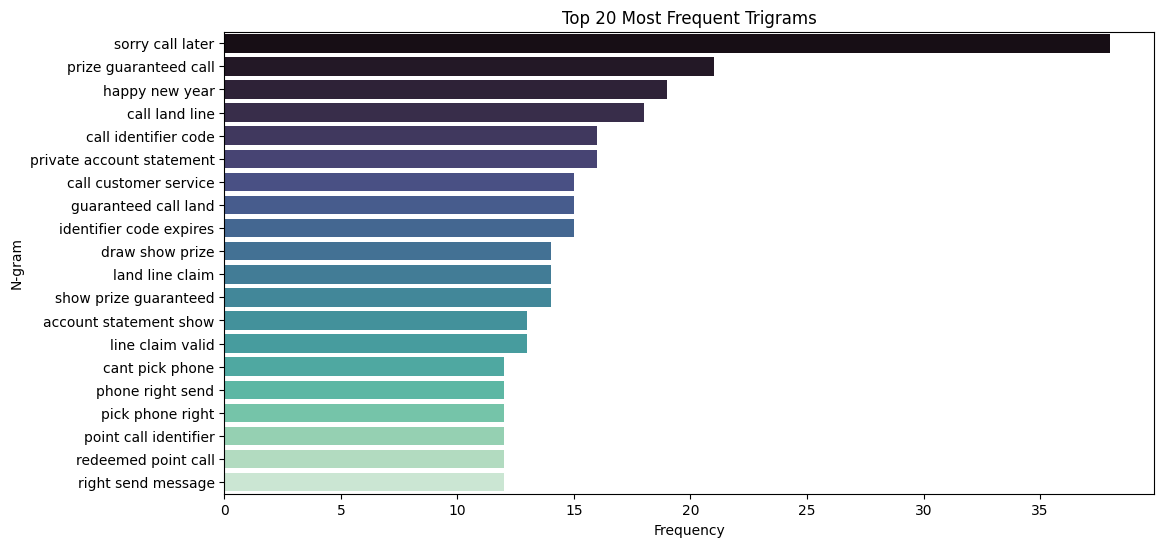

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Convert lists of lemmatized tokens back into full strings
texts = df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize CountVectorizer for bigrams (2-word phrases), limit to top 50 features
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=50)
bigram_matrix = bigram_vectorizer.fit_transform(texts)
bigram_counts = bigram_matrix.sum(axis=0).A1  # Convert sparse matrix to array
bigram_vocab = bigram_vectorizer.get_feature_names_out()

# Initialize CountVectorizer for trigrams (3-word phrases), limit to top 50 features
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=50)
trigram_matrix = trigram_vectorizer.fit_transform(texts)
trigram_counts = trigram_matrix.sum(axis=0).A1
trigram_vocab = trigram_vectorizer.get_feature_names_out()

# Function to plot bar chart for top N-grams
def plot_ngram_bar(vocab, counts, title):
    # Sort by frequency
    sorted_idx = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
    vocab = [vocab[i] for i in sorted_idx[:20]]
    counts = [counts[i] for i in sorted_idx[:20]]

    # Create horizontal bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts, y=vocab, palette='mako')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.show()

# Plot the top 20 most frequent bigrams and trigrams
plot_ngram_bar(bigram_vocab, bigram_counts, "Top 20 Most Frequent Bigrams")
plot_ngram_bar(trigram_vocab, trigram_counts, "Top 20 Most Frequent Trigrams")

# Word Cloud

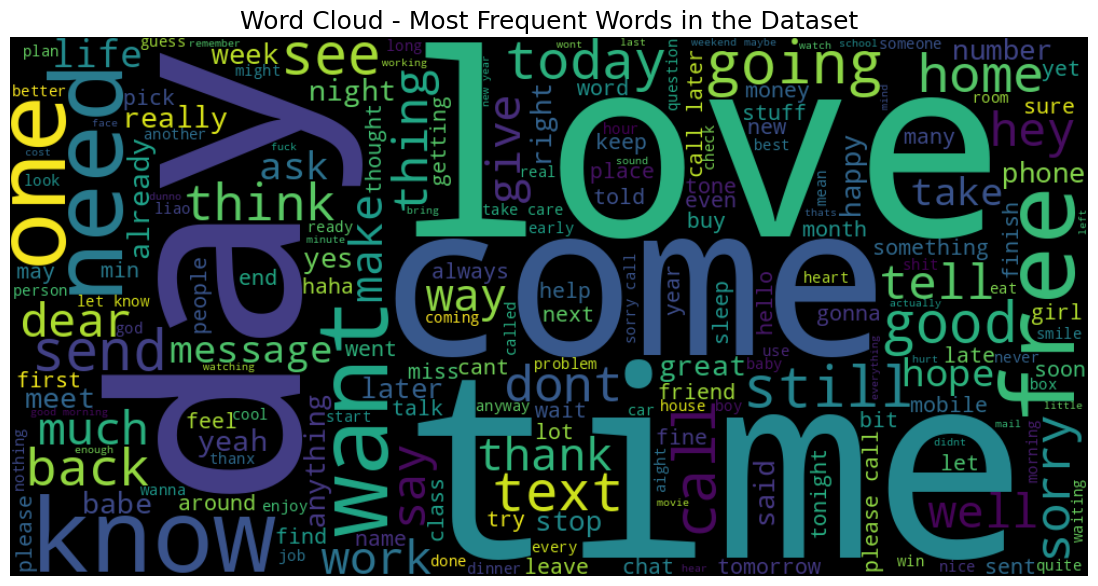

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all lemmatized tokens into a single string for the word cloud
all_text = " ".join([" ".join(tokens) for tokens in df['lemmatized_tokens']])

# Create a WordCloud object with custom settings
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='black',
    max_words=200  # Limit to the top 200 most frequent words
).generate(all_text)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Most Frequent Words in the Dataset", fontsize=18)
plt.show()

# Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-21-fd5013f59da9>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=df, palette='coolwarm')


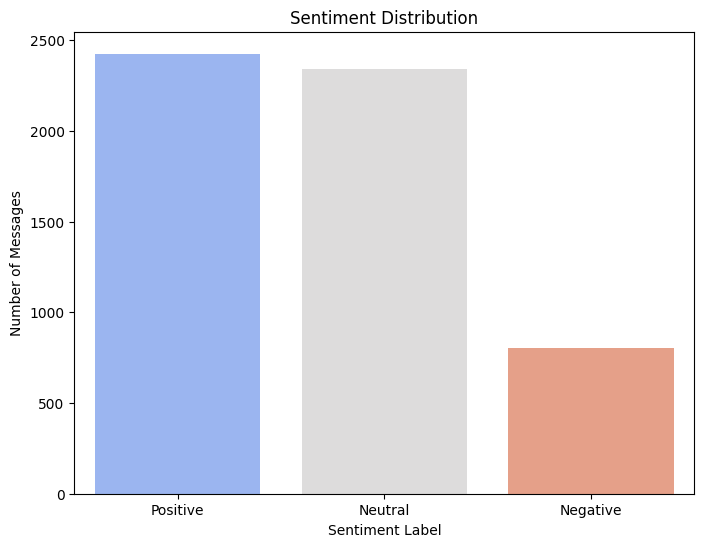

In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Download the VADER lexicon used for sentiment analysis
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute the compound sentiment score for each message
df['sentiment_score'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Define a function to label sentiment based on compound score
def get_sentiment_label(score):
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment labeling to the DataFrame
df['sentiment_label'] = df['sentiment_score'].apply(get_sentiment_label)

# Visualize the distribution of sentiment labels
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_label', data=df, palette='coolwarm')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Messages")
plt.show()

In [22]:
documents = df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer:
# - max_df=0.95: ignore terms that appear in more than 95% of documents (very common)
# - min_df=5: ignore terms that appear in fewer than 5 documents (very rare)
# - stop_words='english': remove standard English stopwords
vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')

# Transform the documents into a document-term matrix
doc_term_matrix = vectorizer.fit_transform(documents)

In [24]:
from sklearn.decomposition import LatentDirichletAllocation

# Initialize the LDA model
# - n_components=5: number of topics to discover
# - random_state=42: ensures reproducibility
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)

# Fit the LDA model to the document-term matrix and transform it into topic distributions
lda_output = lda_model.fit_transform(doc_term_matrix)

In [25]:
# Function to print the top words for each topic in the LDA model
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        # Get indices of the top n words for the current topic
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

# Get the feature (word) names from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Print top words for each topic
print_top_words(lda_model, feature_names)

Topic #1: come, sorry, later, going, stop, tell, home, work, thing, ask
Topic #2: free, know, mobile, text, claim, min, prize, win, cash, let
Topic #3: send, message, way, right, phone, buy, money, pick, fine, dont
Topic #4: like, think, make, love, yeah, know, dont, need, life, say
Topic #5: good, day, time, love, great, happy, want, said, night, hope


<ipython-input-26-850dadb47d8b>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='dominant_topic', data=df, palette='Set2')


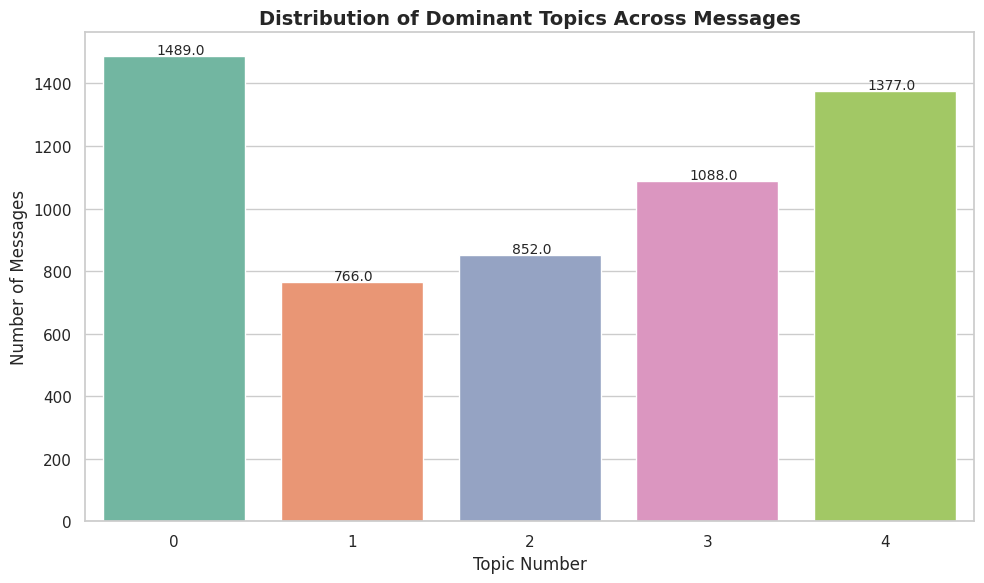

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get topic distribution for each document using the trained LDA model
topic_values = lda_model.transform(doc_term_matrix)

# Assign the most probable topic (dominant topic) to each message
df['dominant_topic'] = topic_values.argmax(axis=1)

# Set seaborn style for better visual appearance
sns.set(style="whitegrid")

# Plot the distribution of dominant topics across all messages
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='dominant_topic', data=df, palette='Set2')

# Annotate each bar with its count value
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 5), fontsize=10)

# Customize plot labels and formatting
plt.title("Distribution of Dominant Topics Across Messages", fontsize=14, weight='bold')
plt.xlabel("Topic Number", fontsize=12)
plt.ylabel("Number of Messages", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

# LDA

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Combine cleaned, lemmatized tokens into full strings (one per document)
documents = df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

# Create a document-term matrix using CountVectorizer
# - max_df=0.95: exclude very common words (in more than 95% of docs)
# - min_df=5: exclude very rare words (in fewer than 5 docs)
# - stop_words='english': remove standard English stopwords
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=5,
    stop_words='english'
)
doc_term_matrix = vectorizer.fit_transform(documents)

# Initialize and train the LDA model with 5 topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [28]:
# Display the top 10 words with the highest weight for each topic
words = vectorizer.get_feature_names_out()

for index, topic in enumerate(lda.components_):
    print(f"\n🟢 Topic {index + 1}:")
    # Get the indices of the top 10 words in the topic
    top_words = [words[i] for i in topic.argsort()[-10:]]
    print(" ".join(top_words))


🟢 Topic 1:
ask thing work home tell stop going later sorry come

🟢 Topic 2:
let cash win prize min claim text mobile know free

🟢 Topic 3:
dont fine pick money buy phone right way message send

🟢 Topic 4:
say life need dont know yeah love make think like

🟢 Topic 5:
hope night said want happy great love time day good


In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

# Combine cleaned tokens into strings (e.g., ['hello', 'world'] → 'hello world')
documents = df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

# 1. Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(
    max_df=0.95,         # Ignore words that appear in more than 95% of documents (too common)
    min_df=5,            # Include only words that appear in at least 5 documents
    stop_words='english'  # Remove standard English stopwords
)
doc_term_matrix = vectorizer.fit_transform(documents)

# 2. Initialize and fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# 3. Print the top 10 keywords for each topic
words = vectorizer.get_feature_names_out()

for index, topic in enumerate(lda.components_):
    print(f"\n🟢 Topic {index + 1}:")
    top_words = [words[i] for i in topic.argsort()[-10:]]  # Top 10 highest-weighted words
    print(" ".join(top_words))

# 4. Assign the dominant topic to each document (message)
topic_values = lda.transform(doc_term_matrix)
df['dominant_topic'] = topic_values.argmax(axis=1)



🟢 Topic 1:
ask thing work home tell stop going later sorry come

🟢 Topic 2:
let cash win prize min claim text mobile know free

🟢 Topic 3:
dont fine pick money buy phone right way message send

🟢 Topic 4:
say life need dont know yeah love make think like

🟢 Topic 5:
hope night said want happy great love time day good


<ipython-input-30-26940d127800>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dominant_topic', data=df, palette='Set2')


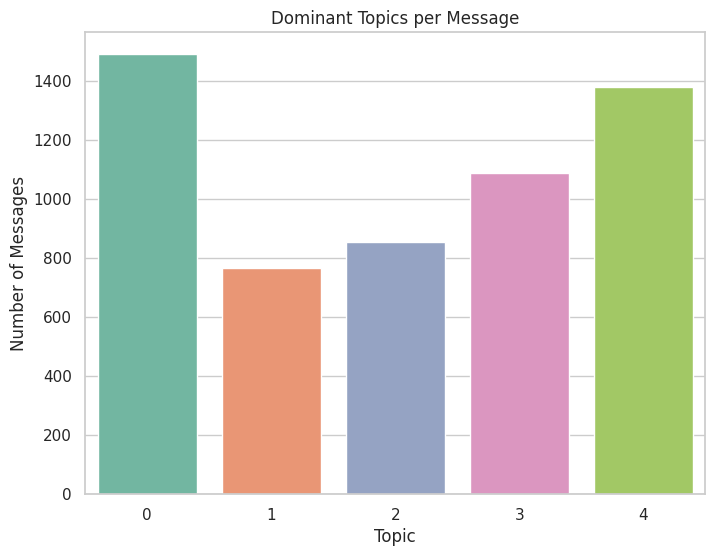

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the topic distribution for each message from the LDA model
topic_values = lda.transform(doc_term_matrix)

# Assign the most dominant topic to each message (i.e., the topic with the highest probability)
df['dominant_topic'] = topic_values.argmax(axis=1)

# Plot the distribution of dominant topics across all messages
plt.figure(figsize=(8, 6))
sns.countplot(x='dominant_topic', data=df, palette='Set2')
plt.title("Dominant Topics per Message")
plt.xlabel("Topic")
plt.ylabel("Number of Messages")
plt.show()

In [31]:
from sklearn.model_selection import train_test_split

# Prepare features (X) by joining lemmatized tokens into strings
X = df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# Target variable (y) is the message label: 'ham' or 'spam'
y = df['label']

# Split the dataset into training and testing sets
# - test_size=0.2: 20% of data goes to the test set
# - stratify=y: preserve the proportion of classes (ham/spam) in both sets
# - random_state=42: ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer (default settings: unigrams only, no stopword removal)
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data and transform it
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test data using the same fitted vectorizer
X_test_vec = vectorizer.transform(X_test)

# **Model Selection and Training**

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Define a dictionary of candidate models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(),
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier()
}

# Evaluate each model using 5-fold cross-validation
# Use F1-score (weighted) to account for class imbalance
for name, model in models.items():
    scores = cross_val_score(model, X_train_vec, y_train, cv=5, scoring='f1_weighted')
    print(f"{name} F1-Score: {scores.mean():.4f} ± {scores.std():.4f}")

Logistic Regression F1-Score: 0.9404 ± 0.0060
Random Forest F1-Score: 0.9715 ± 0.0055
SVC F1-Score: 0.9676 ± 0.0046
Naive Bayes F1-Score: 0.9538 ± 0.0093
Decision Tree F1-Score: 0.9579 ± 0.0048


# Fine Tune

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter search space for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],           # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],          # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],          # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],            # Minimum samples required at a leaf node
    'bootstrap': [True, False]                # Whether bootstrap samples are used
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1  # Use all available CPU cores
)

# Fit the model on training data
grid_search_rf.fit(X_train_vec, y_train)

# Display the best parameters and corresponding F1-score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-validation F1-Score:", grid_search_rf.best_score_)

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-validation F1-Score: 0.9767407725064077


In [35]:
from sklearn.pipeline import make_pipeline

# Retrieve the best model found by GridSearchCV
best_rf_model = grid_search_rf.best_estimator_

# Create a pipeline that combines the vectorizer and the best model
# This allows you to pass raw text directly into the pipeline for prediction
pipeline = make_pipeline(vectorizer, best_rf_model)

In [38]:
import shap
# Convert sparse test matrix to dense format (required for SHAP)
X_test_array = X_test_vec.toarray()

# Create a SHAP explainer for the trained Random Forest model
# Use the dense version of the training data for background reference
explainer = shap.Explainer(best_rf_model, X_train_vec.toarray())

# Compute SHAP values for the test set
shap_values = explainer(X_test_array)

100%|===================| 2227/2230 [06:03<00:00]       

 98%|===================| 195/200 [00:32<00:00]       

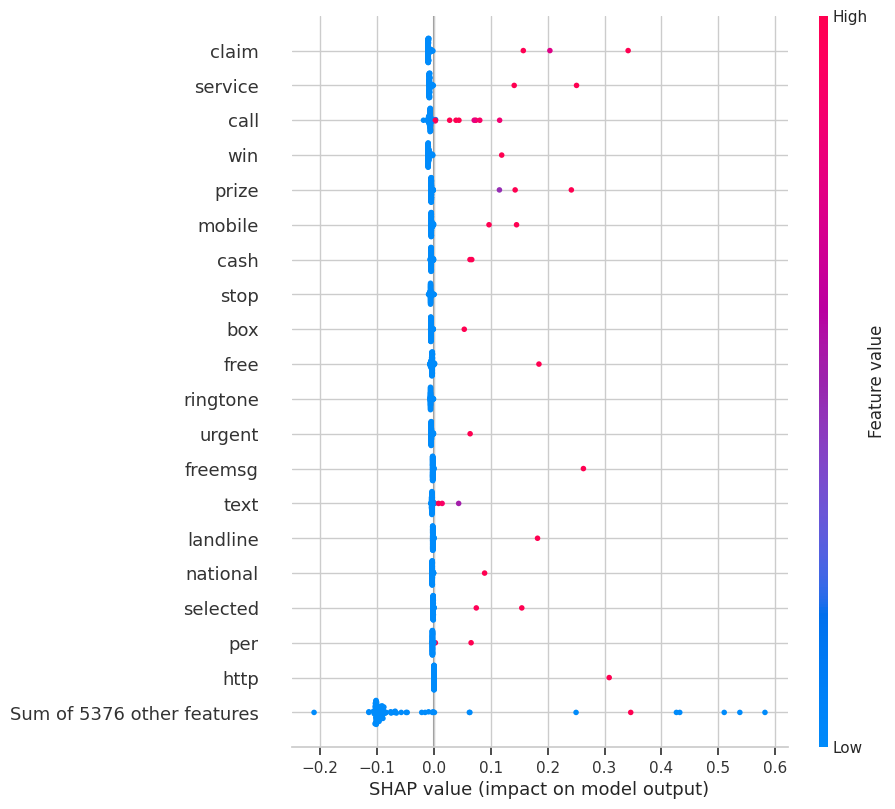

In [39]:
import shap

# Convert TF-IDF vectors to dense format (required by SHAP for tree models)
X_train_array = X_train_vec.toarray()
X_test_array = X_test_vec[:100].toarray()  # Use only the first 100 examples for speed

# Create SHAP explainer for the trained Random Forest model
explainer = shap.Explainer(best_rf_model, X_train_array)

# Calculate SHAP values for the test data
shap_values = explainer(X_test_array)

# Extract SHAP values for class 1 (spam)
shap_spam = shap_values[..., 1]

# Assign feature names from the vectorizer to SHAP values
shap_spam.feature_names = vectorizer.get_feature_names_out()

# Plot a beeswarm summary of SHAP values for class 1 (spam)
shap.plots.beeswarm(shap_spam, max_display=20)

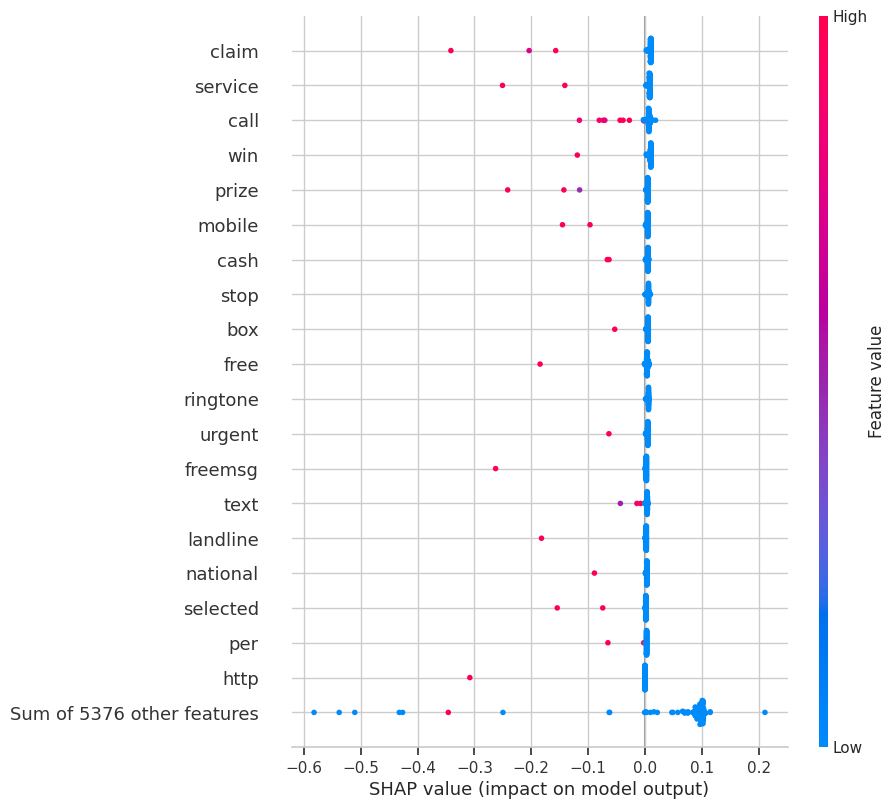

In [40]:
# Extract SHAP values for class 0 (ham)
shap_ham = shap_values[..., 0]

# Assign feature names from the TF-IDF vectorizer
shap_ham.feature_names = vectorizer.get_feature_names_out()

# Generate a beeswarm plot for the ham class
shap.plots.beeswarm(shap_ham, max_display=20)

In [50]:
import shap

# Convert to dense format
X_train_array = X_train_vec.toarray()
X_test_array = X_test_vec.toarray()

# Use the appropriate SHAP explainer
explainer = shap.Explainer(best_rf_model, X_train_array)

# Compute SHAP values
shap_values = explainer(X_test_array)

100%|===================| 2224/2230 [06:04<00:00]       

In [43]:
# Find the first spam message in the test set
# Loop through the y_test labels to identify the first occurrence of a 'spam' label
# Once found, print the index and the corresponding message text from X_test

for i in range(len(y_test)):
    if y_test.iloc[i] == 'spam':
        print(f"Index: {i}, Message: {X_test.iloc[i]}")
        break

Index: 3, Message: cash prize claim call


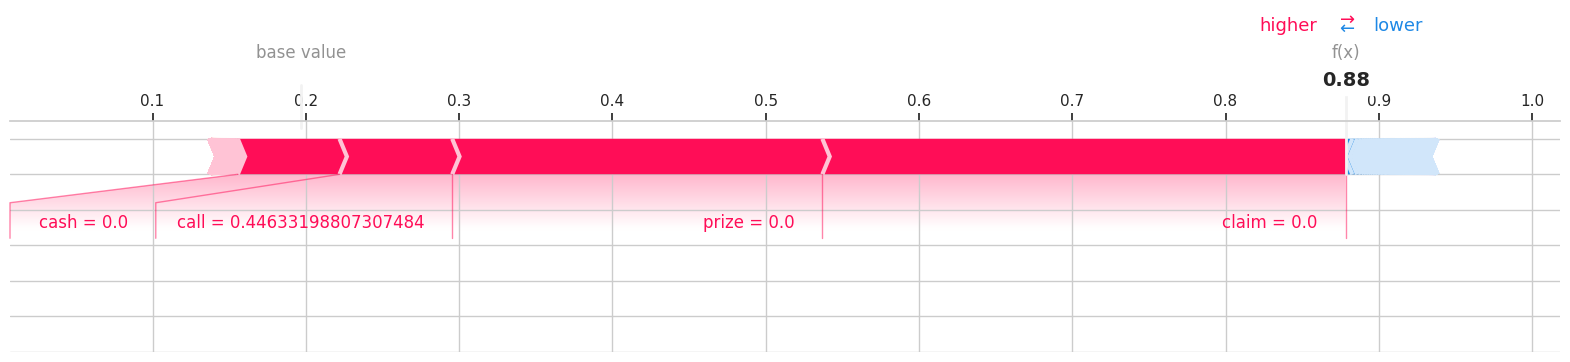

In [44]:
# Generate a SHAP force plot to explain the prediction for a single test instance (index 3)

shap.force_plot(
    base_value=explainer.expected_value[1],            # Base value for class 1 (spam)
    shap_values=shap_values[3].values[:, 1],          # SHAP values for instance 10, class 1
    features=X_test_array[10],                         # Feature vector for instance 10
    feature_names=vectorizer.get_feature_names_out(),  # Corresponding feature names
    matplotlib=True                                    # Use matplotlib for rendering in notebooks
)

# Testing

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict labels for the test set using the best model from GridSearchCV
y_pred_rf = grid_search_rf.predict(X_test_vec)

# Print evaluation metrics for the test set
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, pos_label='spam'))  # Focus on correctly predicting spam
print("Recall:", recall_score(y_test, y_pred_rf, pos_label='spam'))        # Focus on detecting all spam
print("F1 Score:", f1_score(y_test, y_pred_rf, pos_label='spam'))          # Balance between precision and recall

# Display a full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Test Accuracy: 0.9820627802690582
Precision: 1.0
Recall: 0.8657718120805369
F1 Score: 0.9280575539568345

Classification Report:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [56]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

# Initialize the LIME explainer for text classification
lime_explainer = LimeTextExplainer(class_names=['ham', 'spam'])

# Select a sample message from the test set
i = 3
example_text = X_test.iloc[i]
print("Message:", example_text)
print("True Label:", y_test.iloc[i])

# Generate explanation for the selected message
# 'pipeline' should include both the vectorizer and the trained classifier
lime_exp = lime_explainer.explain_instance(
    example_text,
    pipeline.predict_proba,
    num_features=10  # Show top 10 most influential words
)

# Display explanation in notebook
lime_exp.show_in_notebook(text=True)

Message: cash prize claim call
True Label: spam


In [59]:
from lime.lime_text import LimeTextExplainer

# Define class labels in order used by the model (e.g., ['ham', 'spam'])
class_names = ['ham', 'spam']

# Initialize the LIME text explainer
explainer = LimeTextExplainer(class_names=class_names)

# Select a specific test example (change index as needed)
i = 298
example_text = X_test.iloc[i]
print("Message:", example_text)
print("True Label:", y_test.iloc[i])

# Generate explanation for the selected message using the trained pipeline
exp = explainer.explain_instance(
    example_text,
    pipeline.predict_proba,  # Pipeline includes vectorizer and model
    num_features=8           # Show top 8 influential words
)

# Show the explanation in a notebook-friendly format
exp.show_in_notebook(text=True)

Message: searching good dual mobile
True Label: ham
